<a href="https://colab.research.google.com/github/simonsavine/phasetype/blob/main/markov_chain_simulation_discrete_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
# helper functions

In [3]:
def is_square(R):
  shape = np.shape(R)

  if len(shape) != 2:
    return False

  return shape[0] == shape[1]


def is_proba_vector(P):
  if np.any(P < 0):
    return False

  return np.isclose(np.sum(P),1)

In [4]:
def is_transition_matrix(R):
  shape = np.shape(R)

  if not is_square(R):
    return False

  if shape[0] != shape[1]:
    return False

  n=shape[0]
  for i in range(n):
    if not is_proba_vector(R[:, i]):
      return False

  return True

In [5]:
def is_diagonalizable(R):
  if not is_square(R):
    return False

  ls, V = np.linalg.eig(R)

  return np.abs(np.linalg.det(V)) > 1e-6

In [12]:
def make_random_transition_matrix(n, diagonalizable=True):
  R = np.random.exponential(scale=1, size=(n, n))

  for i in range(n):
    R[:, i] /= np.sum(R[:, i])

  if diagonalizable:
    return R

  if not is_diagonalizable(R):
    return make_random_transition_matrix(n, True)


In [13]:
# end of helper functions

In [14]:
# main class for computation of theoretical probabilities, and sample path simulation
class MarkovChain:

  def __init__(self, R):

    assert is_transition_matrix(R), 'not a transition matrix'

    self.n = np.shape(R)[0]
    self.R = R

  def calc_Rm(self, m=1):
    return np.linalg.matrix_power(R, m)

  # Calculate Pi+m knowing Pi
  def calc_probas(self, Pi, m=1):
    return self.calc_Rm(m) @ Pi

  # Calculate Pr(Xi+m | Xi = k)
  def calc_probas_definitestate(self, k, m=1):
    return self.calc_Rm(m) [:, k]

  def sample_path(self, m, X0):
    x = X0
    xs=[X0]

    for _ in range(1, m):
      # next step probas are in the column of R corresponding to current state
      ps = R[:, x]
      x = np.random.choice(self.n, p=ps)
      xs.append(x)

    return np.array(xs)

  def sample_paths(self, m, X0, M):
    paths = []
    for _ in tqdm.tqdm(range(M),f"simulating {M} paths" ):
      paths.append(self.sample_path(m, X0))

    return np.array(paths)

In [15]:
# test our Markov chain

In [16]:
n = 5
R = make_random_transition_matrix(n)
R

array([[0.17800017, 0.00192748, 0.22907125, 0.22122711, 0.00216197],
       [0.13496262, 0.08123099, 0.39810933, 0.09038788, 0.04882915],
       [0.15133916, 0.60321652, 0.13047233, 0.16995913, 0.65294251],
       [0.19133483, 0.06280378, 0.00425193, 0.1576065 , 0.0591934 ],
       [0.34436323, 0.25082123, 0.23809516, 0.36081937, 0.23687297]])

In [17]:
sums = np.sum(R, axis=0)
assert np.allclose(sums, 1)

In [18]:
chain = MarkovChain(R)

In [19]:
# sample 100,000 paths over 50 steps
# allow 2-3 minutes
m = 50
M = 100000
paths = chain.sample_paths(m = m, X0 = 0, M = M)

simulating 100000 paths: 100%|██████████| 100000/100000 [02:20<00:00, 714.01it/s]


In [20]:
first_path = paths[0, :]
assert len(first_path) == m
first_path

array([0, 2, 0, 4, 2, 4, 2, 1, 2, 1, 4, 4, 2, 0, 4, 2, 2, 0, 1, 2, 2, 0,
       4, 2, 4, 2, 2, 1, 2, 4, 2, 1, 3, 0, 3, 0, 3, 1, 4, 2, 0, 2, 0, 2,
       1, 2, 1, 4, 2, 0])

In [21]:
final_states = paths[:, -1]
assert len(final_states) == M
final_states.shape, final_states[:10]

((100000,), array([0, 2, 4, 2, 1, 1, 1, 2, 1, 1]))

In [22]:
# helper function computes empirical frequencies
def compute_empirical_freqs(sample):
  states, counts = np.unique(sample, return_counts=True)
  freqs = counts / np.sum(counts)
  return freqs

In [23]:
# theoretical probabilities
theoretical_probas = chain.calc_probas_definitestate(0, m - 1)

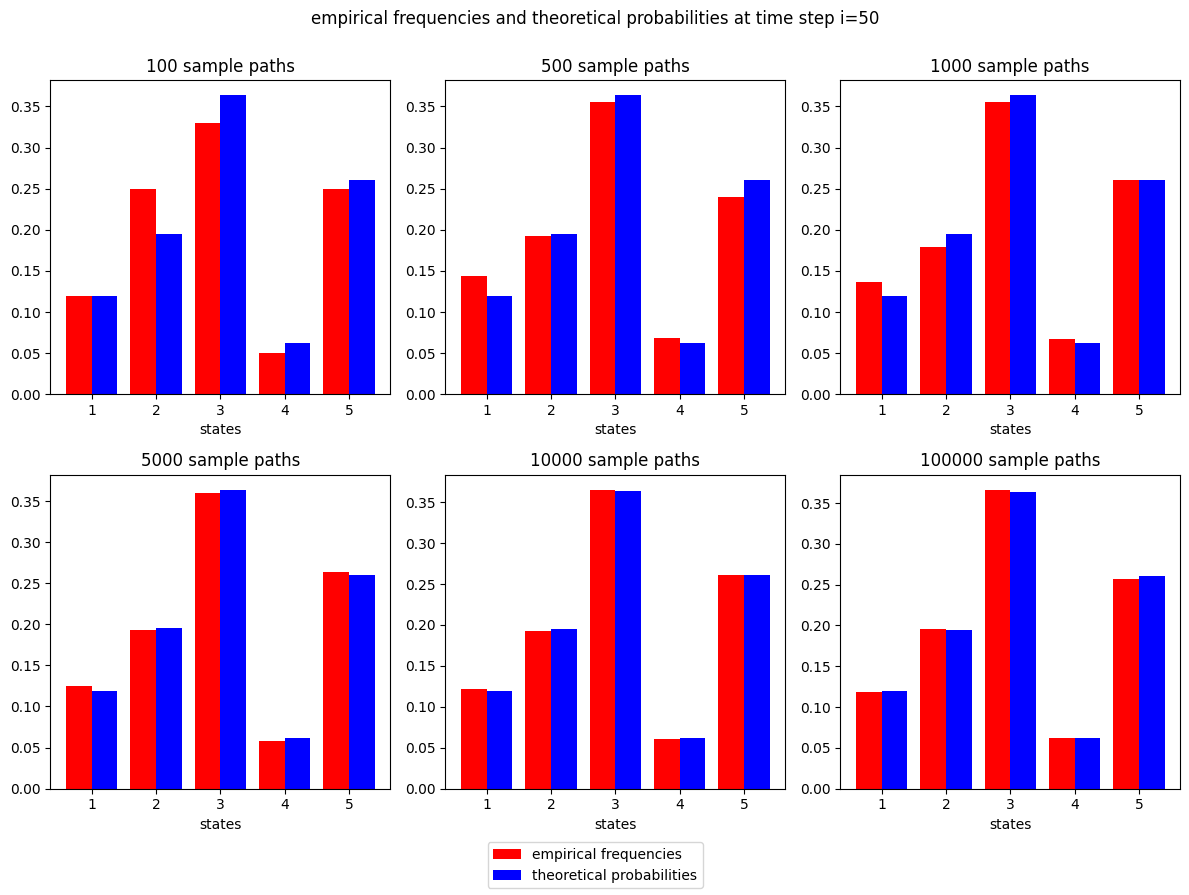

In [24]:
# plot both
states = np.arange(n)
fig, axs = plt.subplots(2, 3, figsize=(12, 9))
axs = axs.flatten()
Ms = [100, 500, 1000, 5000, 10000, 100000]
for ax, M in zip(axs, Ms):
  ax.bar(states + 0.8, compute_empirical_freqs(final_states[:M]), 0.4, color='r', label = 'empirical frequencies')
  ax.bar(states + 1.2, theoretical_probas, 0.4, color='b', label = 'theoretical probabilities')
  ax.set_xlabel("states")
  ax.set_title(f"{M} sample paths")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center")
fig.suptitle("empirical frequencies and theoretical probabilities at time step i=50")
plt.tight_layout(rect=[0, 0.05, 1, 0.98])
